## Game Release Frequency Analysis
This notebook explores the distribution of video game release dates using the filtered dataset from HowLongToBeat. The goal is to identify trends in when games typically launch — by month and by day — across different types of releases.

In [ ]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [15]:
# Load dataset
path = '/kaggle/input/how-long-to-beat-video-game-playtime-dataset/hltb_dataset_filtered.csv'
df = pd.read_csv(path)
pd.set_option('display.max_columns', None)
df.head()

,id,name,type,release_date,release_precision,release_year,release_month,release_day,main_story_polled,main_story,main_plus_sides_polled,main_plus_sides,completionist_polled,completionist,all_styles_polled,all_styles,single_player_polled,single_player,co_op_polled,co_op,versus_polled,versus
0,1,688(I) Hunter/Killer,game,1997-07-04,day,1997.0,7.0,4.0,7.0,10.62,5.0,35.37,2.0,15.83,14.0,20.20,7.0,10.62,NaN,NaN,NaN,NaN
1,18,'Splosion Man,game,2009-07-22,day,2009.0,7.0,22.0,32.0,7.60,21.0,9.23,7.0,18.77,60.0,9.47,32.0,7.60,NaN,NaN,NaN,NaN
2,19,.hack//G.U. Vol. 1: Rebirth,game,2006-10-24,day,2006.0,10.0,24.0,75.0,18.95,78.0,24.50,25.0,37.40,178.0,23.97,75.0,18.95,NaN,NaN,NaN,NaN
3,20,.hack//G.U. Vol. 2: Reminisce,game,2007-05-08,day,2007.0,5.0,8.0,41.0,19.65,31.0,31.73,16.0,48.12,88.0,29.08,41.0,19.65,NaN,NaN,NaN,NaN
4,21,.hack//G.U. Vol. 3: Redemption,game,2008-03-25,day,2008.0,3.0,25.0,34.0,21.25,27.0,30.85,8.0,46.08,69.0,27.88,34.0,21.25,NaN,NaN,NaN,NaN


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51575 entries, 0 to 51574
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      51575 non-null  int64  
 1   name                    51575 non-null  object 
 2   type                    51575 non-null  object 
 3   release_date            49964 non-null  object 
 4   release_precision       49964 non-null  object 
 5   release_year            49964 non-null  float64
 6   release_month           46348 non-null  float64
 7   release_day             44847 non-null  float64
 8   main_story_polled       41854 non-null  float64
 9   main_story              41858 non-null  float64
 10  main_plus_sides_polled  28309 non-null  float64
 11  main_plus_sides         28307 non-null  float64
 12  completionist_polled    32814 non-null  float64
 13  completionist           32821 non-null  float64
 14  all_styles_polled       51052 non-null

In [30]:
# Check for infinities or extremely large values
inf_check = np.isinf(df.select_dtypes(include=['float64'])).sum().sum()
print(f"Infinite values found: {inf_check}")

# Check for duplicate rows
duplicates = df.duplicated().sum()
print(f"\nDuplicate rows: {duplicates}")

Infinite values found: 0

Duplicate rows: 0


In [22]:
df_need = df[['main_story_polled', 'main_story', 'main_plus_sides_polled', 'main_plus_sides',
           'completionist_polled', 'completionist', 'all_styles_polled', 'all_styles',
           'single_player', 'co_op']]

df_need.head()

,main_story_polled,main_story,main_plus_sides_polled,main_plus_sides,completionist_polled,completionist,all_styles_polled,all_styles,single_player,co_op
0,7.0,10.62,5.0,35.37,2.0,15.83,14.0,20.20,10.62,NaN
1,32.0,7.60,21.0,9.23,7.0,18.77,60.0,9.47,7.60,NaN
2,75.0,18.95,78.0,24.50,25.0,37.40,178.0,23.97,18.95,NaN
3,41.0,19.65,31.0,31.73,16.0,48.12,88.0,29.08,19.65,NaN
4,34.0,21.25,27.0,30.85,8.0,46.08,69.0,27.88,21.25,NaN


In [35]:
# Drop rows without valid release date
df = df.dropna(subset=['release_date'])

In [36]:
# Convert release_date to datetime
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')

In [37]:
# Extract month and day
df['release_month'] = df['release_date'].dt.month
df['release_day'] = df['release_date'].dt.day

In [42]:
# Define category
def categorize(row):
    if row['type'] == 'game':
        return 'Game'
    if row['type'] == 'dlc/expansion':
        return 'DLC'
    if (row.get('co_op_polled', 0) > 0) or (row.get('versus_polled', 0) > 0):
        return 'Multiplayer'
    return 'Other'


df['category'] = df.apply(categorize, axis=1)
df = df[df['category'].isin(['Game', 'DLC', 'Multiplayer'])]

In [ ]:
# Data preparation
monthly_counts = df.groupby(['category', 'release_month']).size().unstack(fill_value=0)
monthly_pct = monthly_counts.div(monthly_counts.sum(axis=1), axis=0).T * 100

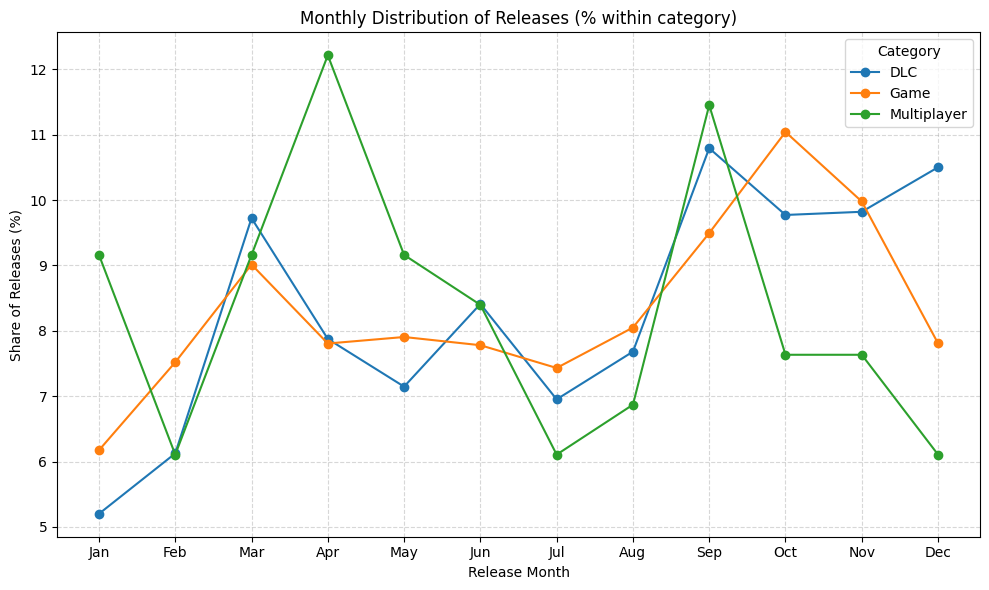

In [45]:
# Percentage of releases per month by category
plt.figure(figsize=(10, 6))
for cat in monthly_pct.columns:
    plt.plot(monthly_pct.index, monthly_pct[cat], marker='o', label=cat)

plt.title('Monthly Distribution of Releases (% within category)')
plt.xlabel('Release Month')
plt.ylabel('Share of Releases (%)')
plt.xticks(range(1, 13), ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title='Category')
plt.tight_layout()
plt.show()

In [ ]:
# Data preparation
monthly_heat = (monthly_counts.T / monthly_counts.sum(axis=1)).T * 100

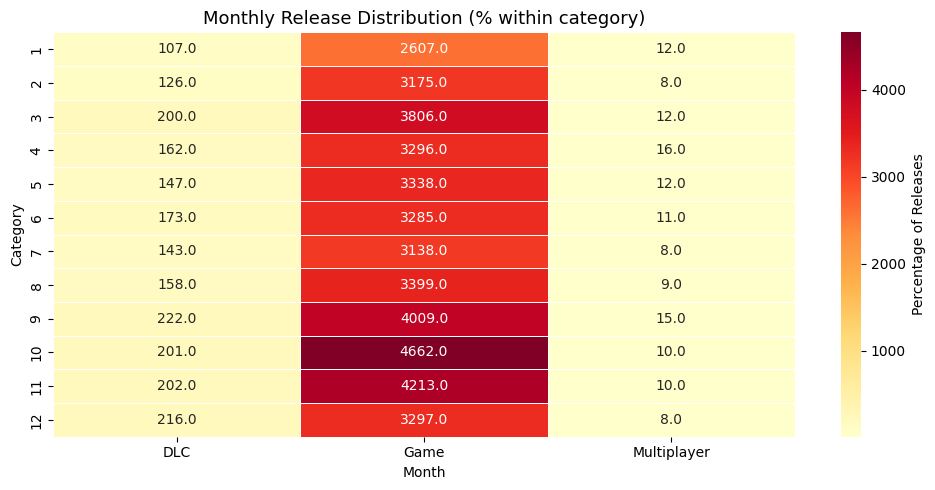

In [47]:
# Monthly heatmap (in % per category)
plt.figure(figsize=(10, 5))
sns.heatmap(
    monthly_heat,
    annot=True, fmt='.1f',
    cmap='YlOrRd', linewidths=0.5, linecolor='white',
    cbar_kws={'label': 'Percentage of Releases'}
)
plt.title('Monthly Release Distribution (% within category)', fontsize=13)
plt.xlabel('Month')
plt.ylabel('Category')
plt.tight_layout()
plt.show()

In [48]:
# Preparation: percentage distribution by day of the month within each category
day_counts = (
    df.groupby(['category', 'release_day'])
    .size()
    .unstack(fill_value=0)
)

In [49]:
# Normalization by lines
day_percentages = (day_counts.T / day_counts.sum(axis=1)).T * 100

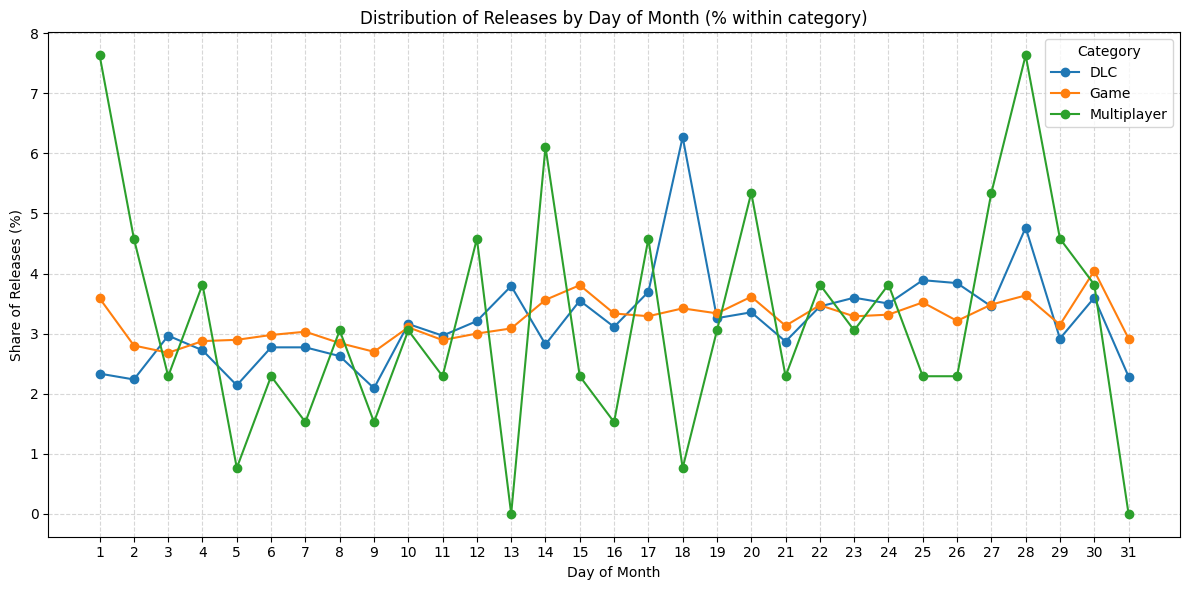

In [50]:
# Linear graph
plt.figure(figsize=(12, 6))
for col in day_percentages.index:
    plt.plot(
        day_percentages.columns, 
        day_percentages.loc[col], 
        marker='o', 
        label=col
    )

plt.title('Distribution of Releases by Day of Month (% within category)')
plt.xlabel('Day of Month')
plt.ylabel('Share of Releases (%)')
plt.xticks(range(1, 32))
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title='Category')
plt.tight_layout()
plt.show()